## SageMaker Stable diffusion Quick Kit 
   [SageMaker Stable Diffusion Quick Kit](https://github.com/aws-samples/sagemaker-stablediffusion-quick-kit) is an asset to help our customers launch stable diffusion models services on Amazon Sagemaker or Amazon EKS.
   
   ![architecture](https://raw.githubusercontent.com/aws-samples/sagemaker-stablediffusion-quick-kit/main/images/architecture.png)

#### Prerequisites
1. Amazon Web Service account 
2. ml.g4dn.xlarge or ml.g5xlarge perfer to used


####  Notebook Step
1. Upgrage boto3, sagemaker python sdk 
2. Deploy AIGC inference service with SageMaker Endpoint service 
   * config model parameter 
   * config async inference
   * deploy SageMaker Endpoint
3. Test inference
4. SageMaker endpoint AutoScaling Config(option)
5. Clear resource

### 1. Upgrage boto3, sagemaker python sdk 

In [1]:
!pip install --upgrade boto3 sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import boto3
import sagemaker
account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = boto3.session.Session().region_name

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

print(f'execution role: {role}')
print(f'default bucket: {bucket}')

execution role: arn:aws:iam::596030579944:role/sagemaker-soln-bs-us-east-1-nb-role
default bucket: sagemaker-us-east-1-596030579944


### 2. Deploy AIGC inference service with SageMaker Endpoint service 

#### 2.1 setup model name and arguments 
   * model_name:  Huggingface diffusers models (not support single check point format)
   * model_args:  diffuser StableDiffusionPipeline init arguments
   * framework_version: pytroch version
   * py_version: python: 3.8 
   * model_environment: inference contianer env 

In [3]:

framework_version = '1.10'
py_version = 'py38'

model_environment = {
    'SAGEMAKER_MODEL_SERVER_TIMEOUT':'600', 
    'SAGEMAKER_MODEL_SERVER_WORKERS': '1', 
    'model_name':'Linaqruf/anything-v3.0',
    's3_bucket':  bucket
}

#### 2.2 Packge inference.py and create fake dummy model_data file, and create PyTorchModel for SageMaker Endpoint.

In [11]:
!rm -rf sourcedir.tar.gz && tar czvf sourcedir.tar.gz -C ../inference/sagemaker/byos/ .
source_dir = 's3://{0}/{1}/source/'.format(bucket, 'stablediffusion')
!aws s3 cp sourcedir.tar.gz $source_dir
source_dir = '{0}sourcedir.tar.gz'.format(source_dir)
!rm -f sourcedir.tar.gz

./
./.ipynb_checkpoints/
./inference.py
./requirements.txt
upload: ./sourcedir.tar.gz to s3://sagemaker-us-east-1-596030579944/stablediffusion/source/sourcedir.tar.gz


In [5]:
!touch dummy
!tar czvf model.tar.gz dummy
assets_dir = 's3://{0}/{1}/assets/'.format(bucket, 'stablediffusion')
model_data = 's3://{0}/{1}/assets/model.tar.gz'.format(bucket, 'stablediffusion')
!aws s3 cp model.tar.gz $assets_dir
!rm -f dummy model.tar.gz

dummy
upload: ./model.tar.gz to s3://sagemaker-us-east-1-596030579944/stablediffusion/assets/model.tar.gz


In [6]:
from sagemaker.pytorch.model import PyTorchModel

model = PyTorchModel(
    name = None,
    model_data = model_data,
    entry_point = 'inference.py',
    source_dir = source_dir,
    role = role,
    framework_version = framework_version, 
    py_version = py_version,
    env = model_environment
)

#### 2.3 Config async inference output , setup config instance_type and name


In [7]:
from sagemaker.async_inference import AsyncInferenceConfig
import uuid

endpoint_name = f'AIGC-Quick-Kit-{str(uuid.uuid4())}'
instance_type = 'ml.g4dn.xlarge'
instance_count = 1
async_config = AsyncInferenceConfig(output_path='s3://{0}/{1}/asyncinvoke/out/'.format(bucket, 'stablediffusion'))

print(f'endpoint_name: {endpoint_name}')

endpoint_name: AIGC-Quick-Kit-54890c93-cee4-4de9-80c8-c7dfa7d976cf


#### 2.4 Deploy SageMaker Endpoint

In [8]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer


async_predictor = model.deploy(
    endpoint_name = endpoint_name,
    instance_type = instance_type, 
    initial_instance_count = instance_count,
    async_inference_config = async_config,
    serializer = JSONSerializer(),
    deserializer = JSONDeserializer()
)

------------!


#### 2.5 Create async inference invoke help function 
 * get_bucket_and_key, read s3 object
 * draw_image, download image from s3 and draw it in notebook
 * async_predict_fn 


In [9]:
import json
import io
from PIL import Image
import traceback
import time
from sagemaker.async_inference.waiter_config import WaiterConfig


s3_resource = boto3.resource('s3')

def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key

def draw_image(response):
    try:
        bucket, key = get_bucket_and_key(response.output_path)
        obj = s3_resource.Object(bucket, key)
        body = obj.get()['Body'].read().decode('utf-8') 
        predictions = json.loads(body)['result']
        print(predictions)
        for prediction in predictions:
            bucket, key = get_bucket_and_key(prediction)
            obj = s3_resource.Object(bucket, key)
            bytes = obj.get()['Body'].read()
            image = Image.open(io.BytesIO(bytes))
            image.show()
    except Exception as e:
        traceback.print_exc()
        print(e)


def async_predict_fn(predictor,inputs):
    response = predictor.predict_async(inputs)
    
    print(f"Response object: {response}")
    print(f"Response output path: {response.output_path}")
    print("Start Polling to get response:")
    
    start = time.time()
    config = WaiterConfig(
        max_attempts=100, #  number of attempts
        delay=10 #  time in seconds to wait between attempts
    )

    response.get_result(config)
    draw_image(response)

    print(f"Time taken: {time.time() - start}s")

### 3. Testing
 3.1 txt2img inference

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7f70637fed70>
Response output path: s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/out/5975e4c8-2e68-481c-9ce4-d2243f491302.out
Start Polling to get response:
['s3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/08bd53ca-0b63-49c6-90cb-53aff4a18c78.jpg', 's3://sagemaker-us-east-1-596030579944/stablediffusion/asyncinvoke/images/c665466f-71b8-49ce-9fbb-5261cfd8e1f4.jpg']


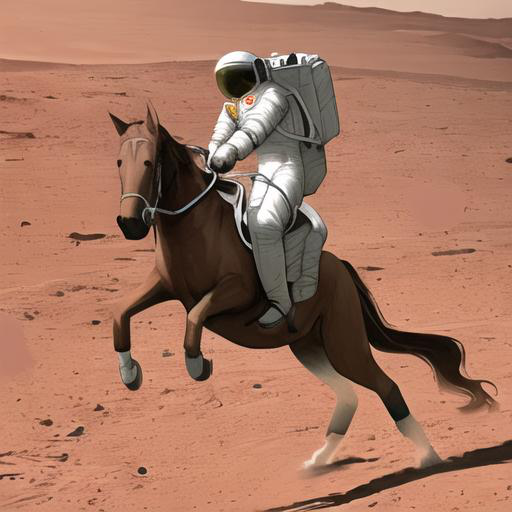

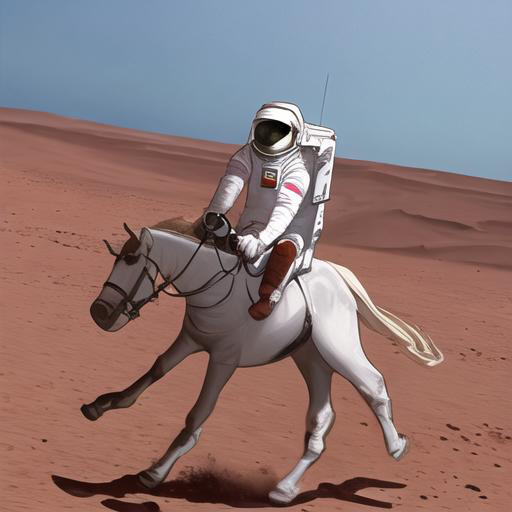

Time taken: 40.874866008758545s


In [10]:
#AIGC Quick Kit txt2img
inputs_txt2img = {
    "prompt": "a photo of an astronaut riding a horse on mars",
    "negative_prompt":"",
    "steps":50,
    "sampler":"ddim",
    #"sampler":"euler_a", your can try other sampler or  steps
    "seed": 52362,
    "height": 512, 
    "width": 512,
    "count":2

}


async_predict_fn(async_predictor,inputs_txt2img)



 3.2 img2img inference

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7f92cc4d0c10>
Response output path: s3://m.flowq.io/stablediffusion/asyncinvoke/out/fe075ac8-777a-4081-a8aa-06d0cea9035d.out
Start Polling to get response:
['s3://m.flowq.io/stablediffusion/asyncinvoke/images/ae8316ae-34ce-43a5-b05c-f3574aaa1ea9.jpg', 's3://m.flowq.io/stablediffusion/asyncinvoke/images/dfbc2ce3-ba98-41b6-959a-493a4bcb9518.jpg']


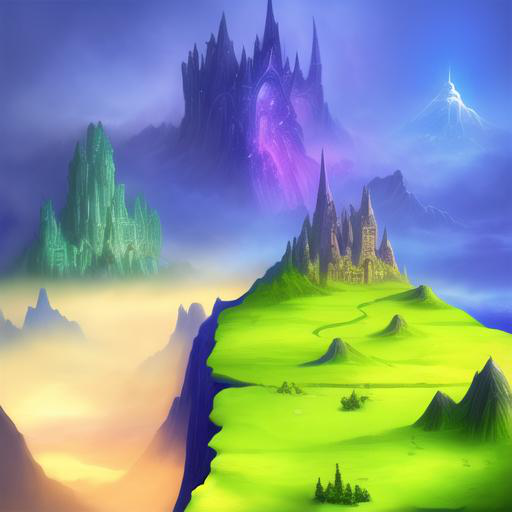

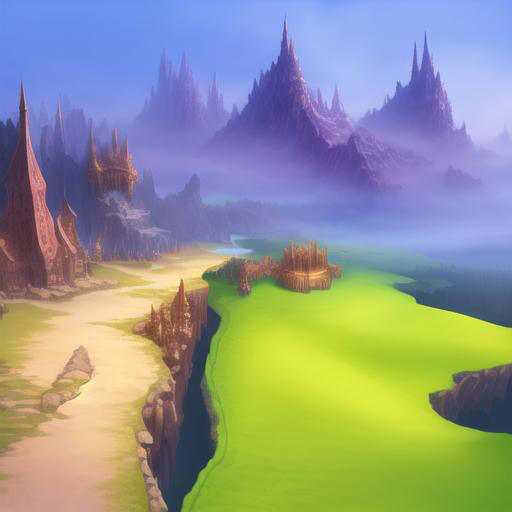

Time taken: 20.564048290252686s


In [34]:
#AIGC Quick Kit img2img

inputs_img2img = {
    "prompt": "A fantasy landscape, trending on artstation",
    "negative_prompt":"",
    "steps":25,
    "sampler":"euler_a",
    "seed":43768,
    "height": 512, 
    "width": 512,
    "count":2,
    "input_image":"https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

}

async_predict_fn(async_predictor,inputs_img2img)

### 4. SageMaker endpoint AutoScaling Config(Option)

In [36]:
# application-autoscaling client
asg_client = boto3.client("application-autoscaling")

# This is the format in which application autoscaling references the endpoint
resource_id = f"endpoint/{async_predictor.endpoint_name}/variant/AllTraffic"

# Configure Autoscaling on asynchronous endpoint down to zero instances
response = asg_client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=1,
    MaxCapacity=2,
)

response = asg_client.put_scaling_policy(
    PolicyName=f'Request-ScalingPolicy-{async_predictor.endpoint_name}',
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 5.0,
        "CustomizedMetricSpecification": {
            "MetricName": "ApproximateBacklogSizePerInstance",
            "Namespace": "AWS/SageMaker",
            "Dimensions": [{"Name": "EndpointName", "Value": async_predictor.endpoint_name}],
            "Statistic": "Average",
        },
        "ScaleInCooldown": 600, # duration until scale in begins (down to zero)
        "ScaleOutCooldown": 300 # duration between scale out attempts
    },
)

In [37]:
import time

start = time.time()

outputs=[]

inputs_txt2img = {
    "prompt": "a photo of an astronaut riding a horse on mars",
    "negative_prompt":"",
    "steps":20,
    "sampler":"euler_a",
    "seed": 52362,
    "height": 512, 
    "width": 512,
    "count":2

}

# send 10 requests
for i in range(10):
    prediction = async_predictor.predict_async(inputs_txt2img)
    outputs.append(prediction)

# iterate over list of output paths and get results
results = []
for output in outputs:
    response = output.get_result(WaiterConfig(max_attempts=600))
    results.append(response)

print(f"Time taken: {time.time() - start}s")
print(results)

Time taken: 272.62122678756714s
[{'result': ['s3://m.flowq.io/stablediffusion/asyncinvoke/images/1afc95ab-6376-42bb-9adc-7d3236a74084.jpg', 's3://m.flowq.io/stablediffusion/asyncinvoke/images/46806b3c-1241-483b-84dc-b65e9929bae4.jpg']}, {'result': ['s3://m.flowq.io/stablediffusion/asyncinvoke/images/a43bcb8c-9f81-4ab8-b7ea-af3ad08b2030.jpg', 's3://m.flowq.io/stablediffusion/asyncinvoke/images/fff06758-a61e-4902-bd75-d180778cc1e6.jpg']}, {'result': ['s3://m.flowq.io/stablediffusion/asyncinvoke/images/56f2c254-3206-4428-9125-68d3303c5f50.jpg', 's3://m.flowq.io/stablediffusion/asyncinvoke/images/b8d5dfe1-aee4-4903-a58b-265f4155f788.jpg']}, {'result': ['s3://m.flowq.io/stablediffusion/asyncinvoke/images/64f986f1-407f-41c0-9988-93da7b9bee9f.jpg', 's3://m.flowq.io/stablediffusion/asyncinvoke/images/7efdc8fd-11f7-4811-b02e-16c83ff56289.jpg']}, {'result': ['s3://m.flowq.io/stablediffusion/asyncinvoke/images/56aa9b17-9b8d-4f70-8fac-f507fabbfed6.jpg', 's3://m.flowq.io/stablediffusion/asyncinvoke

In [ ]:
response = asg_client.deregister_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount'
)


### 5. Clear resource 

In [8]:
async_predictor.delete_endpoint()